# Atom-Doped Photon Engine
*per Tjero et al., 2024*

The dynamics of the quantum system (cavity+atom) can be described by the superator:
$$
\mathcal{U}_{\text{cycle}}=\prod_{k=1}^{4}P_k\mathcal{U}_k\,,
$$

where $P_k$ is the operator performing an energy projective measurement at the end of the stroke $k$.

### Otto Cycle
1-3) **Adiabatic Compression/Expansion**: $\mathcal{U}_k\rho(t) = U_k\rho(t)U_k^\dagger$, with:
$$ U_k = \exp\left(-i\int_{t_{k}}^{t_{k+1}} H_k(t')dt'\right). $$
2-4) **Isochoric Heating/Cooling**: $\mathcal{U}_k = \exp\left(\tau\mathcal{L}_k\right)$, with:
$$ \mathcal{L}_k\rho(t) = -i\left[ H(t_k), \rho(t) \right] + \mathcal{D}_k\left[ \rho(t) \right] $$

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import tqdm
import pickle
from pathlib import Path

from thermophaseonium.utilities.states import Cavity, Ancilla

SAVE_PATH = Path(r"G:\UNIPA\DOTTORATO\PHASEONIUM\thermo-phaseonium\data")

In [2]:
class Engine:
    def __init__(self, ndims=40, l0=10.0, alpha0=2*np.pi, omega_a=None, omega_int=1e-3, omega_dissip=1e-2, v=1e-2, n_c=5, n_h=20, timesteps=1):
        self.ndims = ndims
        self.l0 = l0
        self.alpha0 = alpha0
        self.omega_a = omega_a if omega_a else alpha0 / l0
        self.omega_int = omega_int
        self.omega_dissip = omega_dissip
        self.v = v
        self.v_t = v
        self.n_c = n_c  # Number of thermal photons in the cold bath
        self.n_h = n_h  # Number of thermal photons in the hot bath
        
        cavity = qt.thermal_dm(ndims, n_c)  # Cavity is initially thermalized with the cold bath  
        atom = qt.Qobj([[1, 0], [0, 0]])  # Atom is initially in the ground state
        self._system = qt.tensor(cavity, atom)
        
        self.t = 0  # Actual time of the machine
        self.dt = 1e-4  # Minimum time difference
        self.timesteps = timesteps  # Temporal length of each stroke
        self.l = l0
        self.states = [(self.energy(), self.alpha0 / self.l)]
        
    @property
    def system(self):
        return self._system

    @system.setter
    def system(self, system):
        if system.dims[0][0] != self.ndims:
            raise ValueError('The system state has a different number of dimensions')
        
        self._system = system
        if len(self.states) == 1:
            # Remove all preceding states and start from the new one
            self.states = [(self.energy(), self.alpha0 / self.l)]
        
    def integrate(self, integrand, ti, tf):
        """Perform an approximated integration in the interval [ti, tf] in discrete time"""
        steps = int((tf - ti) / self.dt)
        integral = 0
        for i in np.linspace(ti, tf, steps):
            integral += integrand(i) * self.dt
        return integral
    
    def differentiate(self, f, t):
        """Approximate the derivative of a function f at time t"""
        return (f(t + self.dt) - f(t)) / self.dt
                
    def ha(self):
        """Hamiltonian of the atom"""
        return 0.5 * self.omega_a * qt.sigmaz()
    
    def hc(self):
        """Hamiltonian of the cavity"""
        omega_c = self.alpha0 / self.l
        return omega_c * ( qt.create(self.ndims) * qt.destroy(self.ndims) + 1/2)
    
    def h_int(self):
        """
        Interaction Hamiltonian. 
        The interaction strenght is given by a constant factor times the frequency of the cavity at that time:
        Omega(t) = k*omega_c(t)
        """
        omega_int = self.omega_int * (self.alpha0 / self.l)
        up_term = qt.tensor(qt.create(self.ndims), qt.sigmam())
        down_term = qt.tensor(qt.destroy(self.ndims), qt.sigmap())
        return omega_int * ( up_term + down_term )
    
    def hamiltonian(self, t=0):
        """In this Hamiltonian the time dependance is implicit in the variable self.l"""
        return qt.tensor(self.hc(), qt.qeye(2)) + qt.tensor(qt.qeye(self.ndims), self.ha()) + self.h_int()
    
    def projective_measurement(self, system):
        def basis_state(n, i):
            return qt.tensor(qt.ket2dm(qt.basis(self.ndims, n)), qt.ket2dm(qt.basis(2, i)))
        
        p = sum(basis_state(n, i) for n in range(self.ndims) for i in range(2))
        # system = p * system * p.dag()
        
        # SIMPLIFICATION: Take just the diagonal real part of the density matrix
        system = qt.Qobj(np.diag(system.diag().real), dims=system.dims)
        
        return system
    
    def energy(self):
        return qt.expect(self.hamiltonian(), self.system)
    
    def save(self, filename='engine.pkl'):
        with open(filename, 'wb') as file:
            pickle.dump(engine, file)
            
    def save_system_state(self, filename='system'):
        qt.qsave(self.system, filename)
        
    def load_system_state(self, filename='system'):
        system = qt.qload(filename)
        return system
    
    def load(self, filename='engine.pkl'):
        with open(filename, 'rb') as file:
            engine = pickle.load(file)
        return engine
    
    def plot_length_vs_energy(self, start_from=-1):
        fig, ax = plt.subplots(figsize=(5, 5))
        y = np.array(self.states)[start_from:, 0] 
        x = np.array(self.states)[start_from:, 1]
        ax.plot(x, y)
        ax.set_xlabel('$\omega$')
        ax.set_ylabel('$E\;\;$', rotation=0)
        plt.show()
                
                
class OttoEngine(Engine):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def adiabatic_stroke(self, system):
        steps = int(1 / self.dt)
        
        for i in np.linspace(0, 10, steps):
            # Move the piston
            self.l = self.l + self.v_t * self.dt
            exp = -1j * self.hamiltonian() * self.dt
            u = exp.expm()
            system = u * system * u.dag()

        self.t += 1
        return self.projective_measurement(system)
    
    def isochoric_stroke(self, system, n_th):
        def commutator(rho, hamiltonian):
            return -1j * (hamiltonian * rho - rho * hamiltonian)
        
        def dissipator(rho, n):
            ap = qt.tensor(qt.create(self.ndims), qt.qeye(2))
            am = qt.tensor(qt.destroy(self.ndims), qt.qeye(2))
            up_term = ap * rho * am - 1/2 * ( am * ap * rho + rho * am * ap)
            down_term = am * rho * ap - 1/2 * ( ap * am * rho + rho * ap * am)
            return self.omega_dissip * n * up_term + self.omega_dissip * (n + 1) * down_term
        
        steps = int(1 / self.dt)
        # Here the piston is fixed
        for i in np.linspace(0, 10, steps):
            drdt = commutator(system, self.hamiltonian()) + dissipator(system, n_th)
            system = system + drdt * self.dt
            
        self.t += 1
        return self.projective_measurement(system)
    
    def cycle(self):
        """One pass of the Otto cycle"""
        # 1) Adiabatic Compression
        self.v_t = -1 * abs(self.v)
        self.system = self.adiabatic_stroke(self.system)
        self.states.append((self.energy(), self.alpha0 / self.l))
        
        # 2) Isochoric Heating
        self.v_t = 0
        self.system = self.isochoric_stroke(self.system, self.n_h)
        self.states.append((self.energy(), self.alpha0 / self.l))
        
        # 3) Adiabatic Expansion
        self.v_t = abs(self.v)
        self.system = self.adiabatic_stroke(self.system)
        self.states.append((self.energy(), self.alpha0 / self.l))
        
        # 4) Isochoric Cooling
        self.v_t = 0
        self.system = self.isochoric_stroke(self.system, self.n_c)
        self.states.append((self.energy(), self.alpha0 / self.l))
        
        return self.system
    
    
class CarnotEngine(Engine):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def adiabatic_stroke(self, system):
        steps = int(1 / self.dt)
        
        for i in np.linspace(0, 10, steps):
            # Move the piston
            self.l = self.l + self.v_t * self.dt
            exp = -1j * self.hamiltonian() * self.dt
            u = exp.expm()
            system = u * system * u.dag()

        self.t += 1
        return self.projective_measurement(system)
    
    def isoparametric_stroke(self, system, n_th):
        def commutator(rho, hamiltonian):
            return -1j * (hamiltonian * rho - rho * hamiltonian)
        
        def dissipator(rho, n):
            ap = qt.tensor(qt.create(self.ndims), qt.qeye(2))
            am = qt.tensor(qt.destroy(self.ndims), qt.qeye(2))
            up_term = ap * rho * am - 1/2 * ( am * ap * rho + rho * am * ap)
            down_term = am * rho * ap - 1/2 * ( ap * am * rho + rho * ap * am)
            return self.omega_dissip * n * up_term + self.omega_dissip * (n + 1) * down_term
        
        steps = int(1 / self.dt)
        # Here the piston moves while the system is in contact with the thermal bath
        for i in np.linspace(0, 10, steps):
            # Move the piston
            self.l = self.l + self.v_t * self.dt
            drdt = commutator(system, self.hamiltonian()) + dissipator(system, n_th)
            system = system + drdt * self.dt
            
        self.t += 1
        return self.projective_measurement(system)
    
    def cycle(self):
        """One pass of the Carnot cycle"""
        # 1) Adiabatic Compression
        self.v_t = -1 * abs(self.v)
        self.system = self.adiabatic_stroke(self.system)
        self.states.append((self.energy(), self.alpha0 / self.l))
        
        # 2) Isoparametric Expansion
        self.v_t = abs(self.v)
        self.system = self.isoparametric_stroke(self.system, self.n_h)
        self.states.append((self.energy(), self.alpha0 / self.l))
        
        # 3) Adiabatic Expansion
        self.v_t = abs(self.v)
        self.system = self.adiabatic_stroke(self.system)
        self.states.append((self.energy(), self.alpha0 / self.l))
        
        # 4) Isoparametric Compression
        self.v_t = -1 * abs(self.v)
        self.system = self.isoparametric_stroke(self.system, self.n_c)
        self.states.append((self.energy(), self.alpha0 / self.l))
        
        return self.system
    
    

In [3]:
engine = CarnotEngine(ndims=35, l0=10.0, v=0.01, n_c=1, n_h=4)
# engine.system = engine.load_system_state(SAVE_PATH / 'system')

In [9]:
for c in tqdm.tqdm(range(50)):
    engine.cycle()

100%|██████████| 50/50 [31:18<00:00, 37.56s/it]


In [11]:
len(engine.states)

1001

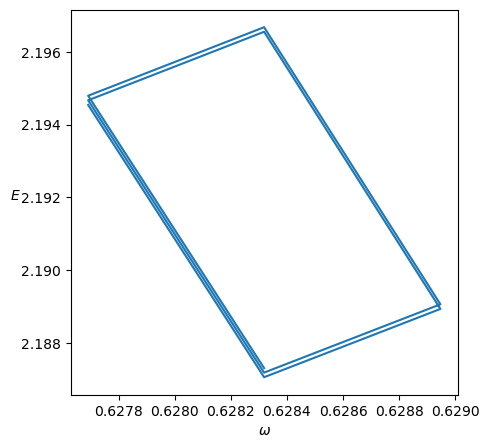

In [17]:
engine.plot_length_vs_energy(start_from=-10)

In [18]:
print(engine.energy())
engine.cycle()
print(engine.energy())

2.1873137358414754
2.1874351345907517


In [19]:
engine.save(SAVE_PATH / 'carnot_engine.pkl')